In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings

epsilon = 10e-80

## An example

In [2]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10


# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020


# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
nr = build_network_representation(matrix, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

nn.w_ampa = w_timed

# Dictionary
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

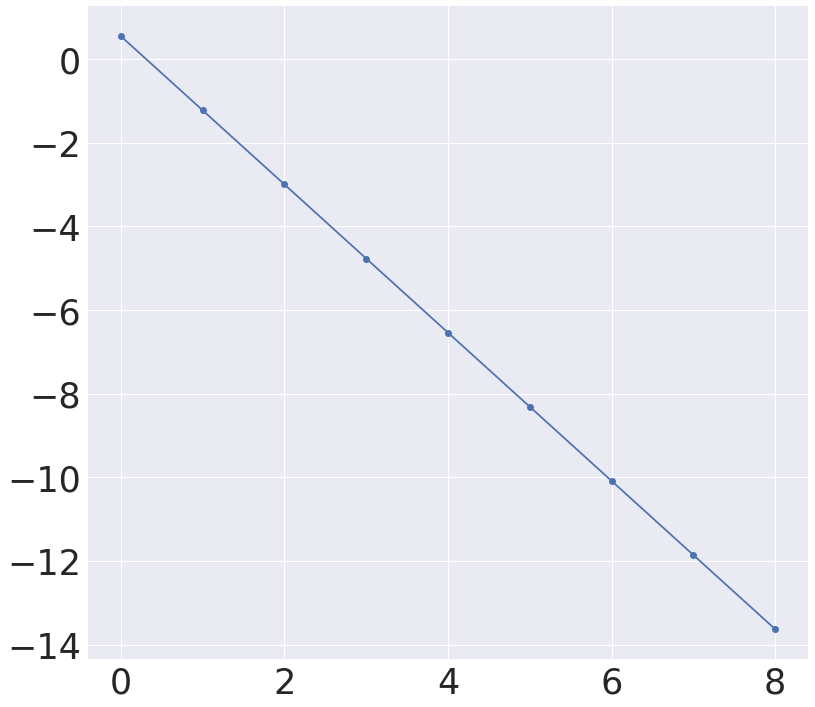

In [3]:
y = w_timed[1:, 0]
X = np.arange(0, y.size, 1)
plt.plot(w_timed[1:, 0], 'o-')

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
regr.coef_[0]

-1.7728766960431588

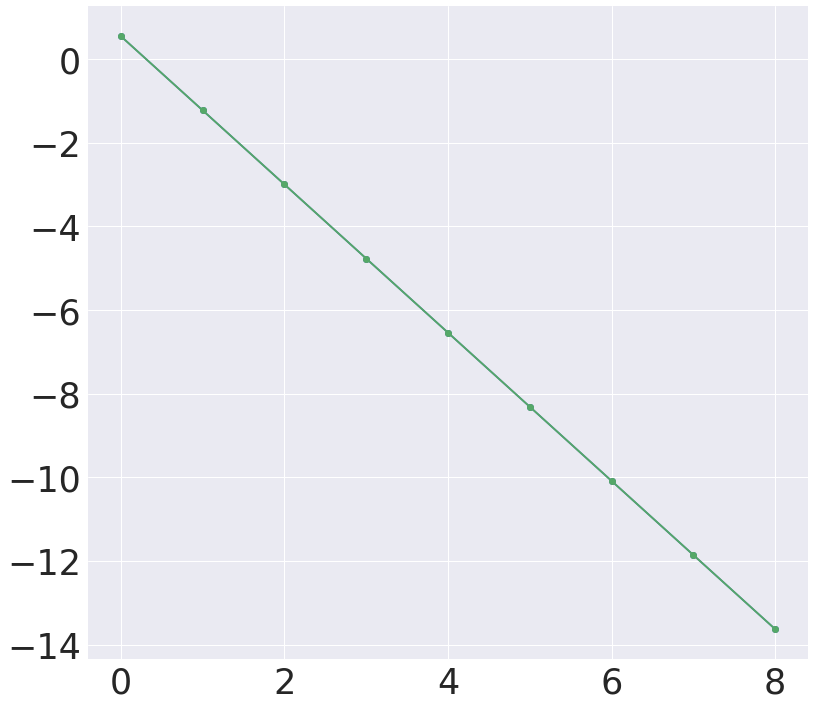

In [6]:
aux = regr.coef_ * X + regr.intercept_
plt.plot(y, 'o-')
plt.plot(aux, 'o-')

## Training time

In [7]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020

num = 20
training_times = np.linspace(0.100, 1.0, num=num)
coeff = []
weights = []

for training_time in training_times:
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

    nn.w_ampa = w_timed
    
    # Training time
    y = w_timed[1:, 0]
    y = y[y > -75]

    X = np.arange(0, y.size, 1)
    regr = LinearRegression()
    regr.fit(X[:, np.newaxis], y)
    
    coeff.append(np.copy(regr.coef_[0]))
    weights.append(np.copy(w_timed[1:, 0]))

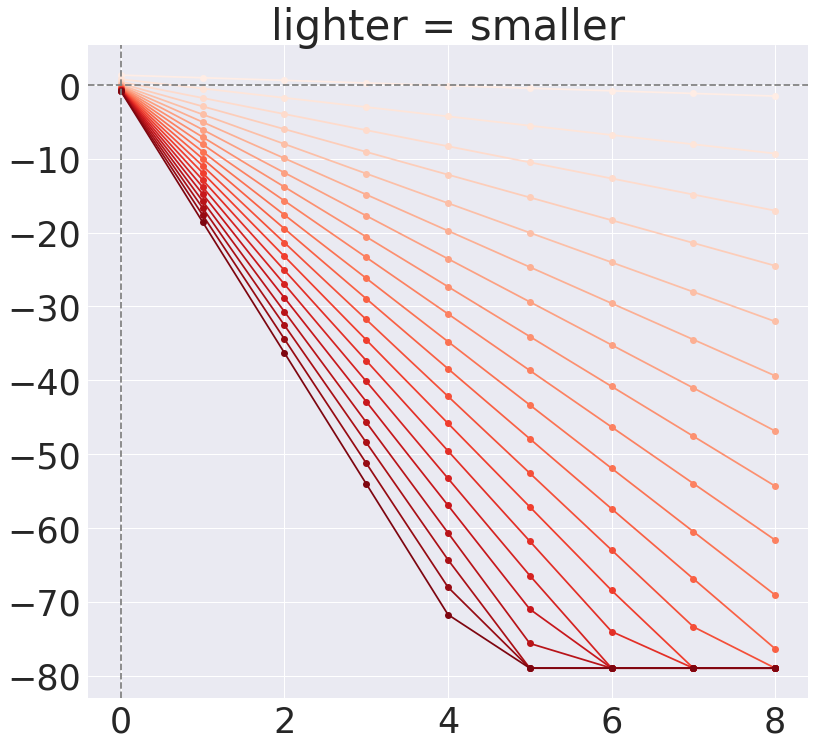

In [8]:
colors = sns.color_palette("Reds", num)


for index, X in enumerate(weights):
    plt.plot(X, 'o-', color=colors[index], label=training_times[index])

plt.title('lighter = smaller')
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

#plt.legend();
    

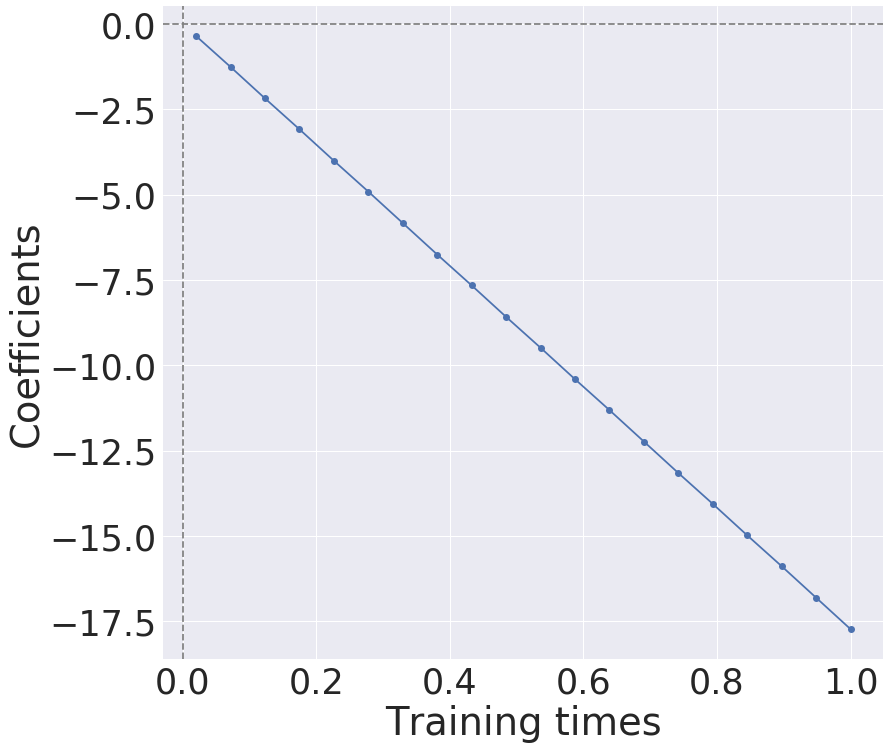

In [9]:
plt.plot(training_times, coeff, 'o-')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel('Training times')
plt.ylabel('Coefficients')

#### small training times

In [13]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020

num = 20
training_times = np.linspace(0.020, 0.100, num=num)
coeff = []
weights = []

for training_time in training_times:
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

    nn.w_ampa = w_timed
    
    # Training time
    y = w_timed[1:, 0]
    y = y[y > -75]

    X = np.arange(0, y.size, 1)
    regr = LinearRegression()
    regr.fit(X[:, np.newaxis], y)
    
    coeff.append(np.copy(regr.coef_[0]))
    weights.append(np.copy(w_timed[1:, 0]))

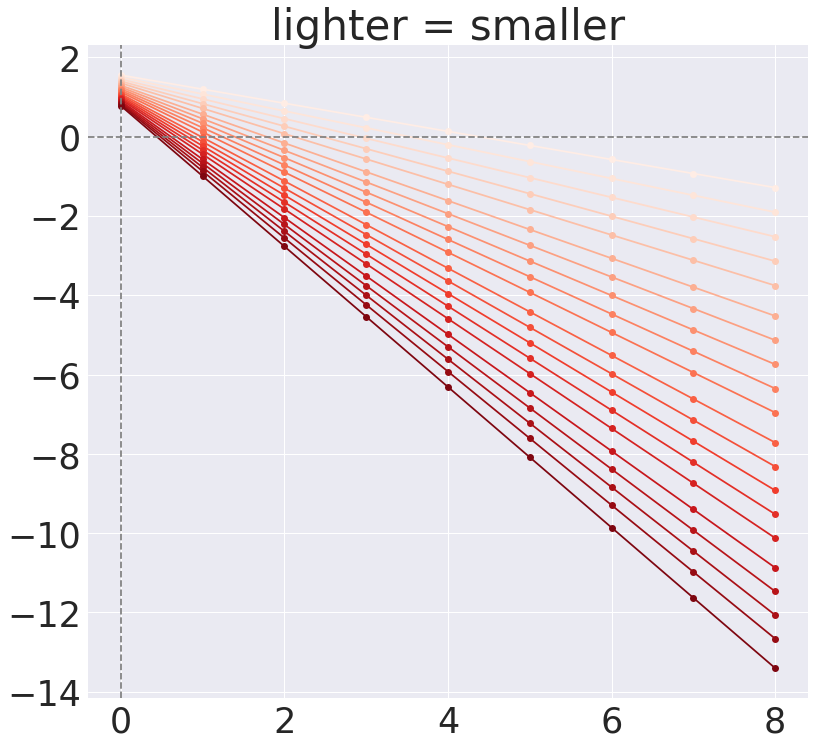

In [14]:
colors = sns.color_palette("Reds", num)

for index, X in enumerate(weights):
    plt.plot(X, 'o-', color=colors[index], label=training_times[index])

plt.title('lighter = smaller')
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

#plt.legend();
    

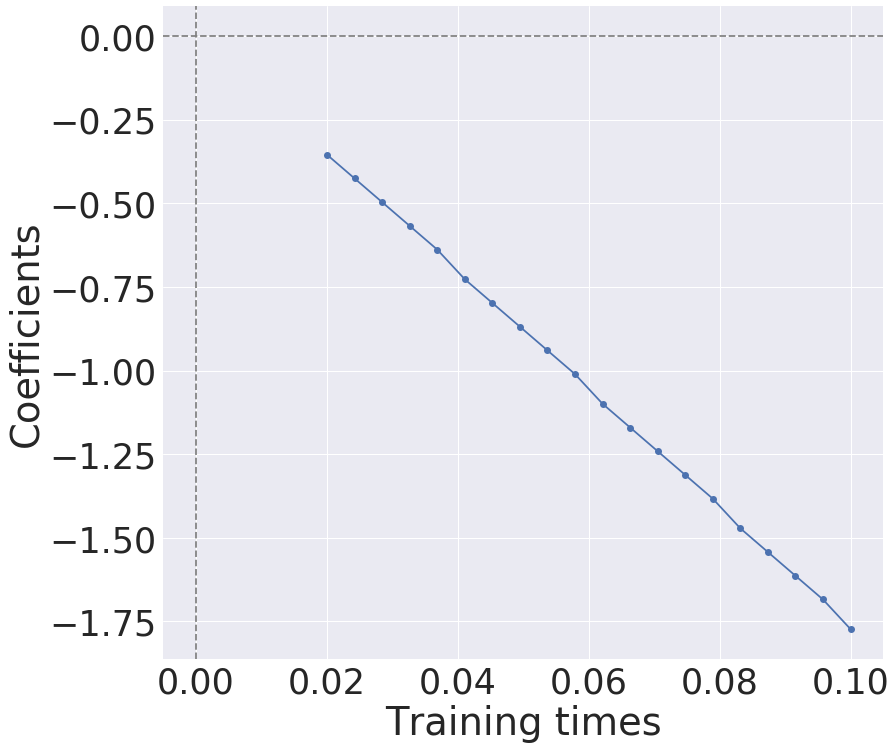

In [15]:
plt.plot(training_times, coeff, 'o-')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel('Training times')
plt.ylabel('Coefficients')

## Tau_z

In [16]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
tau_z_vector = np.linspace(0.025, 0.150, num=num)
coeff = []
weights = []

for tau_z_pre_ampa in tau_z_vector:
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

    nn.w_ampa = w_timed
    
    # Training time
    y = w_timed[1:, 0]
    y = y[y > -75]

    X = np.arange(0, y.size, 1)
    regr = LinearRegression()
    regr.fit(X[:, np.newaxis], y)
    
    coeff.append(np.copy(regr.coef_[0]))
    weights.append(np.copy(w_timed[1:, 0]))

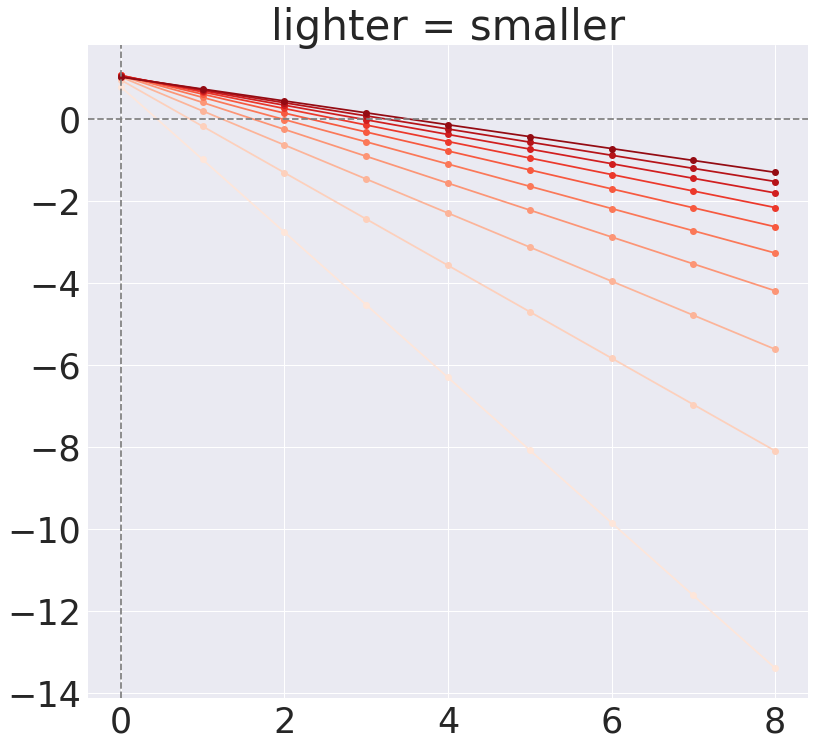

In [17]:
colors = sns.color_palette("Reds", num)


for index, X in enumerate(weights):
    plt.plot(X, 'o-', color=colors[index], label=training_times[index])

plt.title('lighter = smaller')
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

#plt.legend();
    

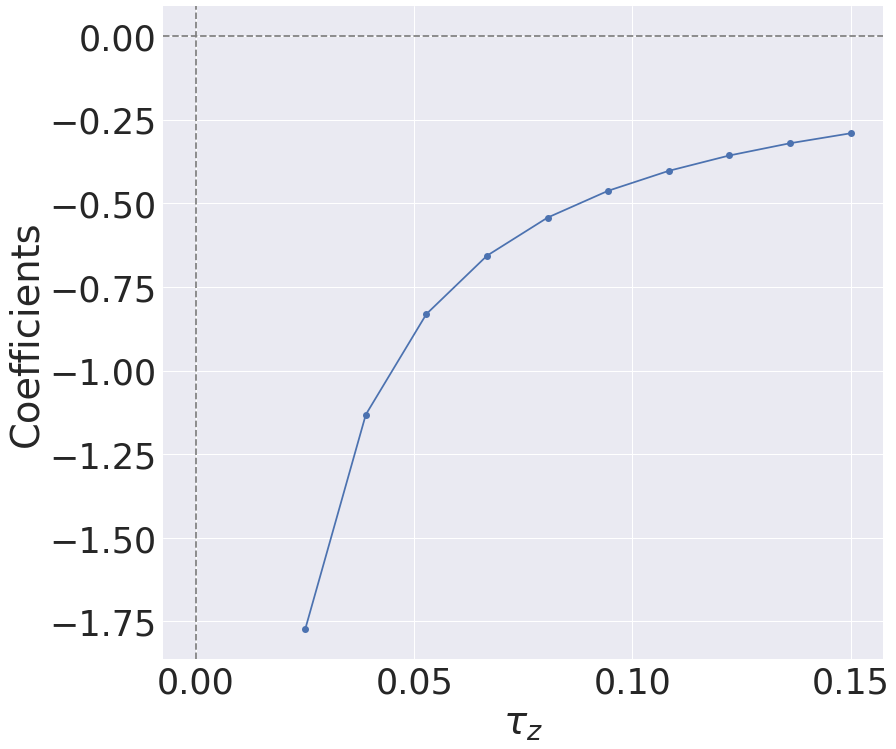

In [18]:
plt.plot(tau_z_vector, coeff, 'o-')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_z$')
plt.ylabel('Coefficients');